## Ajustando Dados a Modelos de Viscosidade

Recebemos medidas experimentais de viscosidade em função da temperatura. Neste notebook, fizemos o ajuste (fit) de curvas de modelos de viscosidade clássicos (AM, VFT e MYEGA) aos dados recebidos.

### Recebendo e plotando os dados:

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
dados = pd.read_excel('CaMgSi2O6.xlsx')
dados = dados.sort_values('temp [K]')
x = np.array(dados['temp [K]'])
y_log = np.array(dados['visc [log10 Pa.s]'])

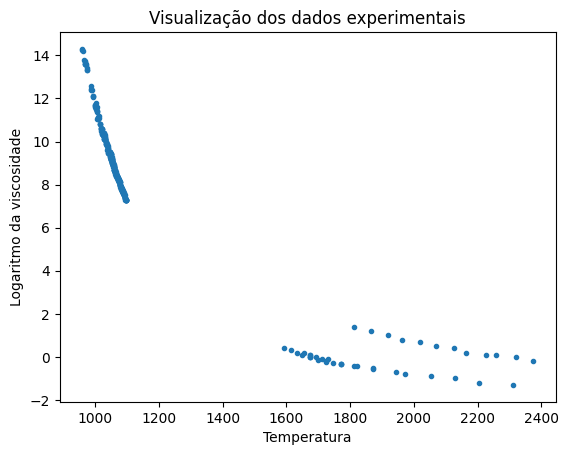

In [3]:
plt.plot(x, y_log, '.', label = "Dados viscosidade")
plt.title('Visualização dos dados experimentais')
plt.xlabel("Temperatura")
plt.ylabel("Logaritmo da viscosidade")
plt.show()

### Definindo as funções matemáticas dos modelos abordados:

Aqui definimos as funções analíticas dos modelos com base no notebook elaborado e disponibilizado pelo orientador Daniel R. Cassar e na referência [1].

In [4]:
def VFT(T, log_eta_inf, m, Tg):
    "Implementando a equação do modelo VFT"
    B= (Tg * (12 - log_eta_inf)**2)/m
    T0= Tg * (1 - (12 - log_eta_inf)/m)
    log_viscosidade = log_eta_inf + B / (T - T0)
    return log_viscosidade

In [5]:
def AM(T, log_eta_inf, m, Tg):
    "Implementando a equação do modelo Avramov-Milchev"
    
    a = m/(12 - log_eta_inf)
    B = Tg * (np.log(10)*(12 - log_eta_inf)) ** ((12 - log_eta_inf)/m)
    log_viscosidade = log_eta_inf + (B/T) ** a
    
    return log_viscosidade

In [6]:
def MYEGA(T, log_eta_inf, m, Tg):
    "Implementendo equação do modelo MYEGA"
    
    log_viscosidade = log_eta_inf + (12 - log_eta_inf) * (Tg/T) * np.exp((((m/(12 - log_eta_inf)) - 1) * ((Tg/T)-1)))
    
    return log_viscosidade

In [7]:
def CW(T, log_eta_inf, m, Tg):
    "Implementendo equação do modelo Cornelissen-Waterman"
    
    a = m/(12 - log_eta_inf)
    B = (12 - log_eta_inf) * (Tg **(m/(12 - log_eta_inf)))
    log_viscosidade = log_eta_inf + B/(T**a)
    
    return log_viscosidade

In [8]:
def F2(T, log_eta_inf, m, Tg):
    "Equação do modelo de Fulcher: expressão 2"
    
    B = ((Tg**2)/3) * (m + 12 - log_eta_inf)
    C = (24 - 2 * log_eta_inf - m)/(3 * Tg)
    
    log_viscosidade = log_eta_inf + B/(T**2) + C * T
    
    return log_viscosidade

In [9]:
def F3(T, log_eta_inf, m, Tg):
    "Equação do modelo de Fulcher: expressão 3"
    
    C = (24 - 2 * log_eta_inf - m)/(2*np.log10(Tg) + (1/np.log(10)))
    B = (12 - log_eta_inf - C * np.log10(Tg) ) * Tg**2
    
    log_viscosidade = log_eta_inf + B/(T**2) + C * np.log10(T)
    
    return log_viscosidade

In [10]:
def F4(T, log_eta_inf, m, Tg):
    "Equação do modelo de Fulcher: expressão 4"
    
    T0 = Tg * (1 - (24 - 2 * log_eta_inf )/m)
    
    B = 4 * Tg * ((12 - log_eta_inf)**3)/(m**2)
    
    log_viscosidade = log_eta_inf + B / ((T - T0)**2)
    
    return log_viscosidade

In [11]:
def CLU(T, log_eta_inf, m, Tg):
    "Implementando equação de Cukierman-Lane-Uhlmann"
    a = Tg/(m + (1/(2*np.log(10))))
    T0 = Tg - (12 - log_eta_inf - (np.log10(Tg)/2)) * a
    B = ((12 - log_eta_inf - (np.log10(Tg)/2))**2) * a
    log_viscosidade = log_eta_inf + (np.log10(T)/2) + B/(T - T0)
    return log_viscosidade

In [12]:
def BS(T, log_eta_inf, m, Tg):
    "Implementando equação de Blender e Shlesinger"
    a = (3*(12 - log_eta_inf))/2*m
    T0 = Tg * (1 - a)
    B = Tg * (12 - log_eta_inf) * (a ** (3/2))
    log_viscosidade = log_eta_inf + B/((T - T0)**(3/2))
    return log_viscosidade

In [13]:
def Bassler(T, log_eta_inf, m, Tg):
    "Implementando equação de Bässler"
    B = Tg * np.sqrt(12 - log_eta_inf)
    log_viscosidade = log_eta_inf + (B/T)**2
    return log_viscosidade

In [14]:
def FF(T, log_eta_inf, m, Tg):
    "Modelo de Fan & Fecht"
    B = (Tg/2)*(m + 12 - log_eta_inf)
    C = (12 - log_eta_inf - m)/(2 * Tg)
    log_viscosidade = log_eta_inf + B/T  + C * T
    
    return log_viscosidade

In [15]:
def Demetriou_et_al(T, log_eta_inf, m, Tg):
    "Modelo de Demetriou, Harmon, Tao, Duan, Samwer e Johnson"
    a = ((m/(12 - log_eta_inf)) - 1)
    Tw = Tg / a
    B = Tg * (12 - log_eta_inf) * np.exp(a)
    log_viscosidade = log_eta_inf + (B/T) * np.exp(-(T/Tw))
    return log_viscosidade

### Criando instâncias dos modelos:

Com o módulo lmfit criamos instâncias dos modelos, assim definimos quem são as variáveis independentes em cada modelo, e os parâmetros que desejamos encontrar para ajustar as curvas.

In [16]:
from lmfit import Model

modelo_VFT = Model(VFT)

print(f'Variável independente: {modelo_VFT.independent_vars}')
print(f'Parâmetros do modelo: {modelo_VFT.param_names}')

Variável independente: ['T']
Parâmetros do modelo: ['log_eta_inf', 'm', 'Tg']


In [17]:
modelo_AM = Model(AM)

print(f'Variável independente: {modelo_AM.independent_vars}')
print(f'Parâmetros do modelo: {modelo_AM.param_names}')

Variável independente: ['T']
Parâmetros do modelo: ['log_eta_inf', 'm', 'Tg']


In [18]:
modelo_MYEGA = Model(MYEGA)

print(f'Variável independente: {modelo_MYEGA.independent_vars}')
print(f'Parâmetros do modelo: {modelo_MYEGA.param_names}')

Variável independente: ['T']
Parâmetros do modelo: ['log_eta_inf', 'm', 'Tg']


In [19]:
modelo_CW = Model(CW)

print(f'Variável independente: {modelo_CW.independent_vars}')
print(f'Parâmetros do modelo: {modelo_CW.param_names}')

Variável independente: ['T']
Parâmetros do modelo: ['log_eta_inf', 'm', 'Tg']


In [20]:
modelo_F2 = Model(F2)

print(f'Variável independente: {modelo_F2.independent_vars}')
print(f'Parâmetros do modelo: {modelo_F2.param_names}')

Variável independente: ['T']
Parâmetros do modelo: ['log_eta_inf', 'm', 'Tg']


In [21]:
modelo_F3 = Model(F3)

print(f'Variável independente: {modelo_F3.independent_vars}')
print(f'Parâmetros do modelo: {modelo_F3.param_names}')

Variável independente: ['T']
Parâmetros do modelo: ['log_eta_inf', 'm', 'Tg']


In [22]:
modelo_F4 = Model(F4)

print(f'Variável independente: {modelo_F4.independent_vars}')
print(f'Parâmetros do modelo: {modelo_F4.param_names}')

Variável independente: ['T']
Parâmetros do modelo: ['log_eta_inf', 'm', 'Tg']


In [23]:
modelo_CLU = Model(CLU)

print(f'Variável independente: {modelo_CLU.independent_vars}')
print(f'Parâmetros do modelo: {modelo_CLU.param_names}')

Variável independente: ['T']
Parâmetros do modelo: ['log_eta_inf', 'm', 'Tg']


In [24]:
modelo_BS = Model(BS)

print(f'Variável independente: {modelo_BS.independent_vars}')
print(f'Parâmetros do modelo: {modelo_BS.param_names}')

Variável independente: ['T']
Parâmetros do modelo: ['log_eta_inf', 'm', 'Tg']


In [25]:
modelo_Bassler = Model(Bassler)

print(f'Variável independente: {modelo_Bassler.independent_vars}')
print(f'Parâmetros do modelo: {modelo_Bassler.param_names}')

Variável independente: ['T']
Parâmetros do modelo: ['log_eta_inf', 'm', 'Tg']


In [26]:
modelo_FF = Model(FF)

print(f'Variável independente: {modelo_FF.independent_vars}')
print(f'Parâmetros do modelo: {modelo_FF.param_names}')

Variável independente: ['T']
Parâmetros do modelo: ['log_eta_inf', 'm', 'Tg']


In [27]:
modelo_Demetriou = Model(Demetriou_et_al)

print(f'Variável independente: {modelo_Demetriou.independent_vars}')
print(f'Parâmetros do modelo: {modelo_Demetriou.param_names}')

Variável independente: ['T']
Parâmetros do modelo: ['log_eta_inf', 'm', 'Tg']


### Parâmetros

Aqui definimos os parâmetros iniciais (palpites) que servirão de base para o fit. Os valores foram retirados das duas referências [1], [2]. Para fins didáticos, durante a elaboração deste notebook, testamos valores arbitrários diferentes para fazer comparações e análise dos resultados.

In [28]:
params = modelo_VFT.make_params(log_eta_inf= -4, m=60, Tg=1000)
params2 = modelo_AM.make_params(log_eta_inf= -4, m=60, Tg=500)
params3 = modelo_MYEGA.make_params(log_eta_inf= -4, m= 60, Tg = 500)
params4 = modelo_CW.make_params(log_eta_inf= -4, m= 60, Tg = 500)
params5 = modelo_F2.make_params(log_eta_inf= -4, m= 60, Tg = 500)
params6 = modelo_F3.make_params(log_eta_inf= -4, m= 60, Tg = 500)
params7 = modelo_F4.make_params(log_eta_inf= 1, m= 60, Tg = 1000)
params8 = modelo_CLU.make_params(log_eta_inf= -4, m= 60, Tg = 1000)
params9 = modelo_BS.make_params(log_eta_inf= 10, m= 60, Tg = 1000)
params10 = modelo_Bassler.make_params(log_eta_inf= -4, m= 60, Tg = 500)
params11 = modelo_Demetriou.make_params(log_eta_inf= -4, m= 60, Tg = 500)

### Regressão não-linear:

Com o método fit encontramos os melhores parâmetros para ajustar a curva aos dados, desde que o palpite inicial torne isso possível. Também mostramos os resultados do fit. O "chi-square" é uma maneira de avaliar qual modelo ajustou melhor os dados (quanto menor melhor).

In [29]:
resultado_fit = modelo_VFT.fit(y_log, params, T=x)
print(resultado_fit.fit_report())

[[Model]]
    Model(VFT)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 332
    # variables        = 3
    chi-square         = 27.1997103
    reduced chi-square = 0.08267389
    Akaike info crit   = -824.640311
    Bayesian info crit = -813.224906
[[Variables]]
    log_eta_inf: -3.46114320 +/- 0.08897547 (2.57%) (init = -4)
    m:            63.3437445 +/- 0.68940440 (1.09%) (init = 60)
    Tg:           995.261911 +/- 0.50646767 (0.05%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, Tg)           = 0.702
    C(log_eta_inf, m)  = 0.574
    C(log_eta_inf, Tg) = 0.293


In [30]:
resultado_fit.params

name,value,standard error,relative error,initial value,min,max,vary
log_eta_inf,-3.46114320,0.08897547,(2.57%),-4,-inf,inf,True
m,63.3437445,0.68940440,(1.09%),60,-inf,inf,True
Tg,995.261911,0.50646767,(0.05%),1000,-inf,inf,True


In [31]:
resultado_fit.params['m'].value

63.34374454442814

In [32]:
resultado_fit2 = modelo_AM.fit(y_log, params2, T = x)
print(resultado_fit2.fit_report())

[[Model]]
    Model(AM)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 332
    # variables        = 3
    chi-square         = 17.2202078
    reduced chi-square = 0.05234106
    Akaike info crit   = -976.405066
    Bayesian info crit = -964.989661
[[Variables]]
    log_eta_inf: -0.80050535 +/- 0.05072761 (6.34%) (init = -4)
    m:            59.7940623 +/- 0.49883551 (0.83%) (init = 60)
    Tg:           832.944128 +/- 1.87000444 (0.22%) (init = 500)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, Tg)           = 0.956
    C(log_eta_inf, Tg) = 0.672
    C(log_eta_inf, m)  = 0.456


In [33]:
resultado_fit3 = modelo_MYEGA.fit(y_log, params3, T = x)
print(resultado_fit3.fit_report())

[[Model]]
    Model(MYEGA)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 332
    # variables        = 3
    chi-square         = 19.6485764
    reduced chi-square = 0.05972212
    Akaike info crit   = -932.607186
    Bayesian info crit = -921.191781
[[Variables]]
    log_eta_inf: -1.50479474 +/- 0.06905297 (4.59%) (init = -4)
    m:            60.9350558 +/- 0.53766877 (0.88%) (init = 60)
    Tg:           995.805430 +/- 0.45383330 (0.05%) (init = 500)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, Tg)           = 0.750
    C(log_eta_inf, m)  = 0.585
    C(log_eta_inf, Tg) = 0.366


In [34]:
resultado_fit4 = modelo_CW.fit(y_log, params4, T = x)
print(resultado_fit4.fit_report())

[[Model]]
    Model(CW)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 332
    # variables        = 3
    chi-square         = 17.2202078
    reduced chi-square = 0.05234106
    Akaike info crit   = -976.405066
    Bayesian info crit = -964.989661
[[Variables]]
    log_eta_inf: -0.80050570 +/- 0.05072744 (6.34%) (init = -4)
    m:            59.7940578 +/- 0.49883541 (0.83%) (init = 60)
    Tg:           995.767041 +/- 0.43511919 (0.04%) (init = 500)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, Tg)           = 0.765
    C(log_eta_inf, m)  = 0.456
    C(log_eta_inf, Tg) = 0.279


In [35]:
resultado_fit5 = modelo_F2.fit(y_log, params5, T=x)
print(resultado_fit5.fit_report())

[[Model]]
    Model(F2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 332
    # variables        = 3
    chi-square         = 42.2446116
    reduced chi-square = 0.12840307
    Akaike info crit   = -678.470509
    Bayesian info crit = -667.055104
[[Variables]]
    log_eta_inf: -26.2435971 +/- 0.68713868 (2.62%) (init = -4)
    m:            48.5710058 +/- 0.47717960 (0.98%) (init = 60)
    Tg:           988.367372 +/- 0.75105719 (0.08%) (init = 500)
[[Correlations]] (unreported correlations are < 0.100)
    C(log_eta_inf, m)  = -0.978
    C(m, Tg)           = 0.750
    C(log_eta_inf, Tg) = -0.733


In [36]:
resultado_fit6 = modelo_F3.fit(y_log, params6, T=x)
print(resultado_fit6.fit_report())

[[Model]]
    Model(F3)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 332
    # variables        = 3
    chi-square         = 30.5211793
    reduced chi-square = 0.09276954
    Akaike info crit   = -786.389089
    Bayesian info crit = -774.973684
[[Variables]]
    log_eta_inf: -175.822814 +/- 4.46438598 (2.54%) (init = -4)
    m:            51.3836980 +/- 0.45157822 (0.88%) (init = 60)
    Tg:           990.980350 +/- 0.61864623 (0.06%) (init = 500)
[[Correlations]] (unreported correlations are < 0.100)
    C(log_eta_inf, m)  = -0.963
    C(m, Tg)           = 0.758
    C(log_eta_inf, Tg) = -0.729


In [37]:
resultado_fit7 = modelo_F4.fit(y_log, params7, T=x)
print(resultado_fit7.fit_report())

[[Model]]
    Model(F4)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 332
    # variables        = 3
    chi-square         = 3961.29359
    reduced chi-square = 12.0404060
    Akaike info crit   = 829.091394
    Bayesian info crit = 840.506799
##  Warning: uncertainties could not be estimated:
[[Variables]]
    log_eta_inf:  8.18203542 (init = 1)
    m:           -27466.7633 (init = 60)
    Tg:           87345.9738 (init = 1000)


In [38]:
resultado_fit8 = modelo_CLU.fit(y_log, params8, T=x)
print(resultado_fit8.fit_report())

[[Model]]
    Model(CLU)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 332
    # variables        = 3
    chi-square         = 26.6518337
    reduced chi-square = 0.08100861
    Akaike info crit   = -831.395968
    Bayesian info crit = -819.980563
[[Variables]]
    log_eta_inf: -5.17892953 +/- 0.08889807 (1.72%) (init = -4)
    m:            63.2463772 +/- 0.68077583 (1.08%) (init = 60)
    Tg:           995.284288 +/- 0.50224708 (0.05%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, Tg)           = 0.704
    C(log_eta_inf, m)  = 0.579
    C(log_eta_inf, Tg) = 0.299


# ERRO AQUI NO MODELO BS

In [39]:
resultado_fit9 = modelo_BS.fit(y_log, params9, T=x)
print(resultado_fit9.fit_report())

ValueError: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable. In cases like this, using "nan_policy='omit'" will probably not work.

In [40]:
resultado_fit10 = modelo_Bassler.fit(y_log, params10, T=x)
print(resultado_fit10.fit_report())

[[Model]]
    Model(Bassler)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 24
    # data points      = 332
    # variables        = 3
    chi-square         = 166.335327
    reduced chi-square = 0.50557850
    Akaike info crit   = -223.454887
    Bayesian info crit = -212.039482
##  Warning: uncertainties could not be estimated:
    m:            at initial value
[[Variables]]
    log_eta_inf: -5.02509286 (init = -4)
    m:            60.0000000 (init = 60)
    Tg:           964.762351 (init = 500)


In [41]:
resultado_fit11 = modelo_Demetriou.fit(y_log, params11, T=x)
print(resultado_fit11.fit_report())

[[Model]]
    Model(Demetriou_et_al)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 332
    # variables        = 3
    chi-square         = 15.3858302
    reduced chi-square = 0.04676544
    Akaike info crit   = -1013.80042
    Bayesian info crit = -1002.38501
[[Variables]]
    log_eta_inf: -0.38917565 +/- 0.03992599 (10.26%) (init = -4)
    m:            58.3215893 +/- 0.47026278 (0.81%) (init = 60)
    Tg:           995.647941 +/- 0.42509923 (0.04%) (init = 500)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, Tg)           = 0.783
    C(log_eta_inf, m)  = 0.306
    C(log_eta_inf, Tg) = 0.177


### Plot dos resultados:

Aqui plotamos todos os resultados obtidos com os diferentes modelos, com respectivos palpite inicial e melhor ajuste encontrado. Também plotamos 

In [ ]:
plt.plot(x, y_log, '.')
plt.plot(x, resultado_fit.init_fit, '--', label='Palpite inicial - VFT')
plt.plot(x, resultado_fit.best_fit, '-', label='Melhor ajuste encontrado - VFT')
plt.plot(x, resultado_fit2.init_fit, '--', label = 'Palpite inicial - AM')
plt.plot(x, resultado_fit2.best_fit, '-', label = 'Melhor ajuste encontrado - AM')
plt.plot(x, resultado_fit3.init_fit, '--', label= 'Palpite inicial - MYEGA')
plt.plot(x, resultado_fit3.best_fit, '-', label= 'Melhor ajuste encontrado - MYEGA')
plt.plot(x, resultado_fit4.init_fit, '--', label= 'Palpite inicial - CW')
plt.plot(x, resultado_fit4.best_fit, '-', label= 'Melhor ajuste encontrado - CW')
plt.legend()
plt.show()

In [ ]:
plt.plot(x, y_log, '.')
plt.plot(x, resultado_fit.init_fit, '--', label='Palpite inicial - VFT')
plt.plot(x, resultado_fit.best_fit, '-', label='Melhor ajuste encontrado - VFT')
plt.title("Modelo VFT")
plt.xlabel('Temperatura [K]')
plt.ylabel('Logaritmo da viscosidade')
plt.legend()
plt.show()

Plotamos também gráficos contendo o ajuste e os resíduos de cada modelo. Com isso, pudemos avaliar a performance de cada modelo, comparando apenas a distância dos pontos à curva independente de sua forma.

In [ ]:
resultado_fit.plot(numpoints = 400)
plt.show()

In [ ]:
plt.plot(x, y_log, '.')
plt.plot(x, resultado_fit2.init_fit, '--', label = 'Palpite inicial - AM')
plt.plot(x, resultado_fit2.best_fit, '-', label = 'Melhor ajuste encontrado - AM')
plt.title("Modelo AM")
plt.xlabel('Temperatura [K]')
plt.ylabel('Logaritmo da viscosidade')
plt.legend()
plt.show()

In [ ]:
resultado_fit2.plot(numpoints = 400)
plt.show()

In [ ]:
plt.plot(x, y_log, '.')
plt.plot(x, resultado_fit3.init_fit, '--', label = 'Palpite inicial - MYEGA')
plt.plot(x, resultado_fit3.best_fit, '-', label = 'Melhor ajuste encontrado - MYEGA')
plt.title("Modelo MYEGA")
plt.xlabel('Temperatura [K]')
plt.ylabel('Logaritmo da viscosidade')
plt.legend()
plt.show()

In [ ]:
resultado_fit3.plot(numpoints = 400)
plt.show()

In [ ]:
plt.plot(x, y_log, '.')
plt.plot(x, resultado_fit4.init_fit, '--', label = 'Palpite inicial - CW')
plt.plot(x, resultado_fit4.best_fit, '-', label = 'Melhor ajuste encontrado - CW')
plt.title("Modelo CW")
plt.xlabel('Temperatura [K]')
plt.ylabel('Logaritmo da viscosidade')
plt.legend()
plt.show()

In [ ]:
resultado_fit4.plot(numpoints = 400)
plt.show()

In [ ]:
plt.plot(x, y_log, '.')
plt.plot(x, resultado_fit5.init_fit, '--', label = 'Palpite inicial - F2')
plt.plot(x, resultado_fit5.best_fit, '-', label = 'Melhor ajuste encontrado - F2')
plt.title("Modelo F2")
plt.xlabel('Temperatura [K]')
plt.ylabel('Logaritmo da viscosidade')
plt.legend()
plt.show()

In [ ]:
resultado_fit5.plot(numpoints = 400)
plt.show()

In [ ]:
plt.plot(x, y_log, '.')
plt.plot(x, resultado_fit6.init_fit, '--', label = 'Palpite inicial - F3')
plt.plot(x, resultado_fit6.best_fit, '-', label = 'Melhor ajuste encontrado - F3')
plt.title("Modelo F3")
plt.xlabel('Temperatura [K]')
plt.ylabel('Logaritmo da viscosidade')
plt.legend()
plt.show()

In [ ]:
resultado_fit6.plot(numpoints = 400)
plt.show()

In [ ]:
plt.plot(x, y_log, '.')
plt.plot(x, resultado_fit7.init_fit, '--', label = 'Palpite inicial - F4')
plt.plot(x, resultado_fit7.best_fit, '-', label = 'Melhor ajuste encontrado - F4')
plt.title("Modelo F4")
plt.xlabel('Temperatura [K]')
plt.ylabel('Logaritmo da viscosidade')
plt.legend()
plt.show()

In [ ]:
resultado_fit7.plot(numpoints = 400)
plt.show()

### Repeated K-fold cross validation:

Mudar fold e repetições. Palpite: 5 folds, 6 repetições. 

In [42]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from scipy import stats

In [43]:
rkf = RepeatedKFold(n_splits=5, n_repeats=6, random_state=2652124)

In [58]:
medias = []
scores = []
num_modelos = 6
modelos = {modelo_VFT : params,
           modelo_AM : params2,
           modelo_MYEGA : params3,
           modelo_CW: params4,
          }


In [59]:
for modelo, parametros in modelos.items():

    for i, (train_index, test_index) in enumerate(rkf.split(x)):
        
        x_treino = x[train_index]
        y_treino = y_log[train_index]
        y_teste = y_log[test_index]
        x_teste = x[test_index]

        Resultado = modelo.fit(y_treino, parametros, T = x_treino)

        y_verdadeiro = y_log[test_index]
        y_previsao = Resultado.eval(T = x_teste)
        RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared = False)
        scores.append(RMSE)
        media_modelo = np.mean(scores)    

    medias.append(media_modelo)

In [47]:
score1, score2, score3, score4, score5, score6 = np.array_split(scores, num_modelos)

In [48]:
len(score1)

30

In [49]:
stats.shapiro(score1)

ShapiroResult(statistic=0.9840080738067627, pvalue=0.9191204905509949)

In [50]:
stats.shapiro(score2)

ShapiroResult(statistic=0.9767858386039734, pvalue=0.7351920008659363)

In [51]:
stats.shapiro(score3)

ShapiroResult(statistic=0.9840512871742249, pvalue=0.9199566841125488)

In [52]:
stats.shapiro(score4)

ShapiroResult(statistic=0.9767866134643555, pvalue=0.7352134585380554)

In [53]:
stats.shapiro(score5)

ShapiroResult(statistic=0.8842660188674927, pvalue=0.0035378639586269855)

In [54]:
stats.shapiro(score6)

ShapiroResult(statistic=0.9177742600440979, pvalue=0.02349112369120121)

In [57]:
stats.levene(score1, score2, score3, score4, score5, score6)

LeveneResult(statistic=4.485208764820556, pvalue=0.0007191040468378769)

In [ ]:
score1

In [ ]:
lista = [score1, score2, score3, score4, score5, score6, score7]

In [ ]:
for i in lista:
    print(len(i))

In [ ]:
testes = {
    'ANOVA' : stats.f_oneway(score1,score2,score3, score4, score5, score6, score7),
    'Friedman' : stats.friedmanchisquare(score1, score2, score3, score4, score5, score6, score7)
    }

print('Significância 0.05')
for teste, estatistica in testes.items():
    pvalor = estatistica.pvalue
    print(f'Para o teste {teste}, o P-valor foi: {pvalor}')

In [ ]:
tukey = stats.tukey_hsd(score1,score2,score3, score4, score5, score6, score7)

In [ ]:
print(tukey)

In [ ]:
resultado = tukey.pvalue

In [ ]:
resultado

In [ ]:
plt.plot(x, y_log, '.')
plt.plot(x, resultado_fit2.best_fit, '-', label = 'Melhor ajuste encontrado - AM')

plt.plot(x, resultado_fit7.init_fit, '--', label= 'Palpite inicial - F4')
plt.plot(x, resultado_fit7.best_fit, '-', label= 'Melhor ajuste encontrado - F4')
plt.legend()
plt.show()

### Atual

## Referências:

__[1]__ Mauro, J. C., Yue, Y., Ellison, A. J., Gupta, P. K., & Allan, D. C. (2009). Viscosity of glass-forming liquids. Proceedings of the National Academy of Sciences, 106(49), 19780-19784.

__[2]__ Notebook de regressão não-linear. Daniel R. Cassar. Disponibilizado pelo orientador Daniel R. Cassar.

[3] https://www.statology.org/friedman-test-python/